In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from keras.models import Sequential
from keras.layers import Dense

# I will group by date and number of killed and injured victims 

In [7]:
df = pd.read_csv('../datasets/output/clustered.csv')

In [8]:
df.columns

Index(['incident_id', 'date', 'state', 'city_or_county', 'address', 'n_killed',
       'n_injured', 'incident_url', 'source_url',
       'incident_url_fields_missing', 'congressional_district', 'gun_stolen',
       'gun_type', 'incident_characteristics', 'latitude',
       'location_description', 'longitude', 'n_guns_involved', 'notes',
       'participant_age', 'participant_age_group', 'participant_gender',
       'participant_name', 'participant_relationship', 'participant_status',
       'participant_type', 'sources', 'state_house_district',
       'state_senate_district', 'cluster'],
      dtype='object')

In [10]:
df['date'] = pd.to_datetime(df['date'])
df['Year'] = df['date'].dt.year
df['Month'] = df['date'].dt.month

In [21]:
aggregated_state = df.groupby(['state', 'Year', 'Month']).agg({
    'n_killed': 'sum',
    'n_injured': 'sum',
    'n_guns_involved': 'sum',
}).reset_index()

aggregated_state.head()

,state,Year,Month,n_killed,n_injured,n_guns_involved
0,Alabama,2013,7,0,4,0.0
1,Alabama,2013,12,3,5,0.0
2,Alabama,2014,1,38,50,13.0
3,Alabama,2014,2,16,39,9.0
4,Alabama,2014,3,28,53,45.0


In [99]:
# I will compare the clusters with the states accuracy
df_cl = df[df['cluster'] != -1]
aggregated_cluster = df.groupby(['cluster', 'Year', 'Month']).agg({
    'n_killed': 'sum',
    'n_injured': 'sum',
    'n_guns_involved': 'sum',
}).reset_index()

aggregated_cluster.sort_values(by=['n_killed', 'Year', 'Month']).tail()

,cluster,Year,Month,n_killed,n_injured,n_guns_involved
50,-1.0,2017,7,124,129,589.0
53,-1.0,2017,10,125,94,466.0
56,-1.0,2018,1,137,130,465.0
44,-1.0,2017,1,142,119,459.0
54,-1.0,2017,11,144,148,409.0


# Comparing if clustering or sorting by state shows better result
## 1. Neural net
### For state

In [79]:
encoder = OneHotEncoder()
state_encoded = encoder.fit_transform(aggregated_state[['state']]).toarray()

X = np.hstack((state_encoded, aggregated_state[['Year', 'Month', 'n_injured', 'n_guns_involved']].values))
y = aggregated_state['n_killed'].values

X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

model = Sequential()
model.add(Dense(4096, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, verbose=0)

loss, mae = model.evaluate(X_test, y_test)

/opt/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 418.6498 - mae: 12.7444 - val_loss: 83.2605 - val_mae: 5.9221
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 78.0620 - mae: 5.7281 - val_loss: 65.5199 - val_mae: 5.4829
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 68.4304 - mae: 5.3744 - val_loss: 85.4941 - val_mae: 6.0030
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 51.9086 - mae: 4.7105 - val_loss: 45.5778 - val_mae: 4.6110
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 56.9619 - mae: 4.8732 - val_loss: 42.4836 - val_mae: 4.3483
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 45.8859 - mae: 4.4537 - val_loss: 92.8107 - val_mae: 6.2170
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 57.1568 - mae: 4.8874 - val_loss: 52.5128 - val_mae: 4.8352
Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 41.0271 - mae: 4.1465 - val_loss: 42.2299 - val_mae: 4.4469
Epoch 9/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/

In [83]:
y_test_pred = model.predict(X_test)
r2 = r2_score(y_test, y_test_pred)

print(f"Test MAE: {mae}")
print(f"R² Score: {r2}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Test MAE: 4.6223530769348145
R² Score: 0.9092852473258972


### For clustered

In [101]:
encoder = OneHotEncoder()
cluster_encoded = encoder.fit_transform(aggregated_cluster[['cluster']]).toarray()

X = np.hstack((cluster_encoded, aggregated_cluster[['Year', 'Month', 'n_injured', 'n_guns_involved']].values))
y = aggregated_cluster['n_killed'].values

X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

model_cl = Sequential()
model_cl.add(Dense(4096, input_dim=X_train.shape[1], activation='relu'))
model_cl.add(Dense(512, activation='relu'))
model_cl.add(Dense(256, activation='relu'))
model_cl.add(Dense(128, activation='relu'))
model_cl.add(Dense(64, activation='relu'))
model_cl.add(Dense(1, activation='linear'))

model_cl.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model_cl.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=40, batch_size=32, verbose=0)

loss, mae = model_cl.evaluate(X_test, y_test)

/opt/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.2899 - mae: 1.0871


In [103]:
y_test_pred = model_cl.predict(X_test)
r2 = r2_score(y_test, y_test_pred)

print(f"MAE: {mae}")
print(f"R² Score: {r2}")

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MAE: 1.1141152381896973
R² Score: 0.8925762176513672


## Linear regression for both datasets

### For states

In [93]:
encoder = OneHotEncoder()
state_encoded = encoder.fit_transform(aggregated_state[['state']]).toarray()

X = np.hstack((state_encoded, aggregated_state[['Year', 'Month', 'n_injured', 'n_guns_involved']].values))
y = aggregated_state['n_killed'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model_reg_state = LinearRegression()

model_reg_state.fit(X_train, y_train)

y_test_pred = model_reg_state.predict(X_test)

test_mae = mean_absolute_error(y_test, y_test_pred)

print(f"MAE: {test_mae}")
print(f"R² Score: {model_reg_state.score(X_test, y_test)}")

MAE: 5.3216977757009785
R² Score: 0.8649059855432332


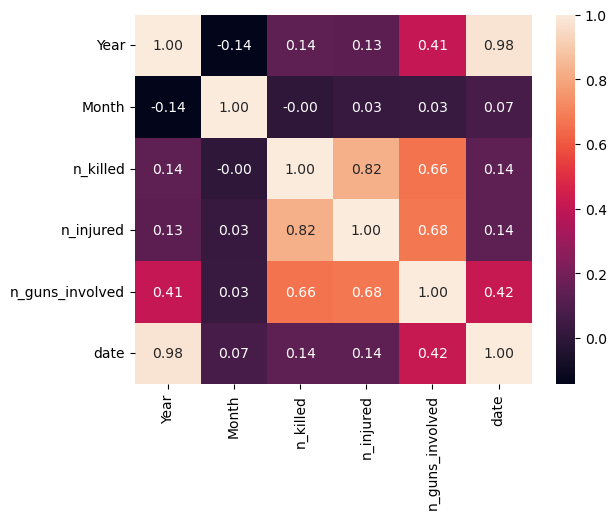

In [94]:
sns.heatmap(aggregated_state.drop(columns='state').corr(), annot=True, fmt=".2f");

Number of killed doesnt depend on month!

### For clustered

In [92]:
encoder = OneHotEncoder()
cluster_encoded = encoder.fit_transform(aggregated_cluster[['cluster']]).toarray()

X = np.hstack((cluster_encoded, aggregated_cluster[['Year', 'Month', 'n_injured', 'n_guns_involved']].values))
y = aggregated_cluster['n_killed'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model_reg_cl = LinearRegression()

model_reg_cl.fit(X_train, y_train)

y_test_pred = model_reg_cl.predict(X_test)

test_mae = mean_absolute_error(y_test, y_test_pred)

print(f"MAE: {test_mae}")
print(f"R² Score: {model_reg_cl.score(X_test, y_test)}")

MAE: 1.1884447184899467
R² Score: 0.8780607743673923


# Some extra EDA

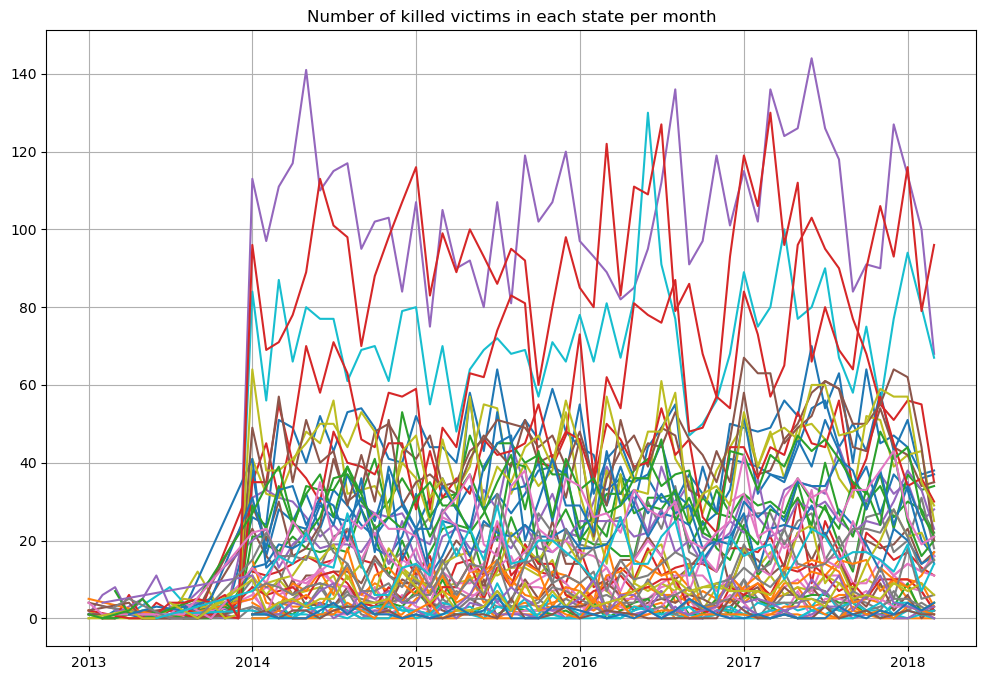

In [72]:
aggregated_state['date'] = pd.to_datetime(aggregated_state[['Year', 'Month']].assign(DAY=1))

plt.figure(figsize=(12, 8))
for state in aggregated_state['state'].unique():
    state_data = aggregated_state[aggregated_state['state'] == state]
    plt.plot(state_data['date'], state_data['n_killed'], label=state)
plt.title('Number of killed victims in each state per month')
plt.grid(True)
plt.show()

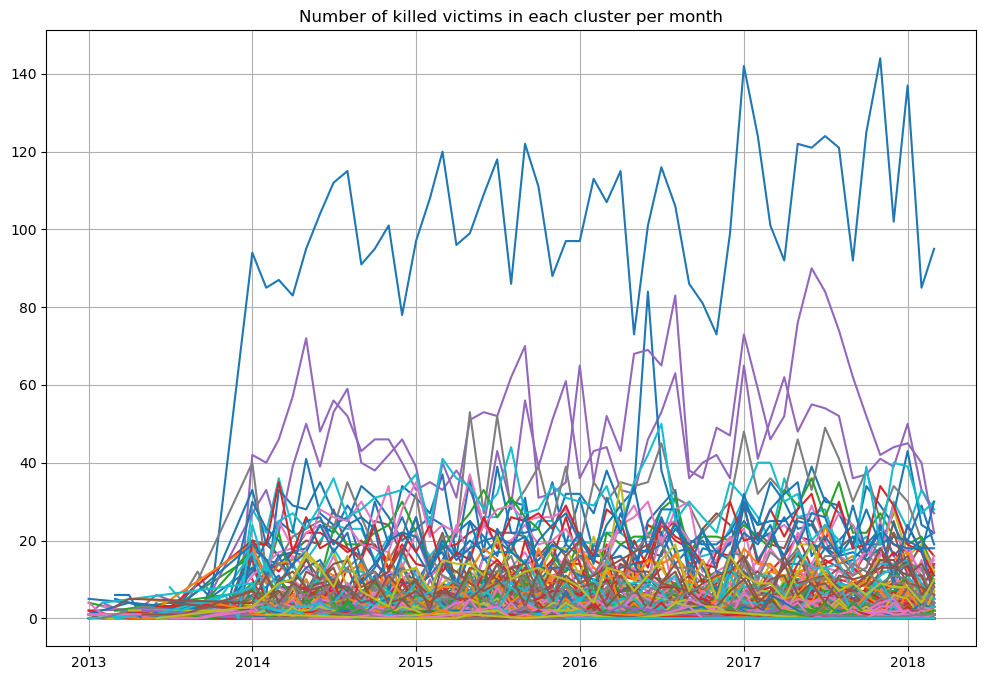

In [75]:
aggregated_cluster['date'] = pd.to_datetime(aggregated_cluster[['Year', 'Month']].assign(DAY=1))

plt.figure(figsize=(12, 8))
for cluster in aggregated_cluster['cluster'].unique():
    cluster_data = aggregated_cluster[aggregated_cluster['cluster'] == cluster]
    plt.plot(cluster_data['date'], cluster_data['n_killed'], label=cluster)
plt.title('Number of killed victims in each cluster per month')
plt.grid(True)
plt.show()

***Basically, number of killings per month both for clusters and states is just noise, which is upredictable***

# Some maps

In [53]:
aggregated_state['n_killed'].mean()

20.634428004330566

In [155]:
aggregated_state['n_injured'].mean()

41.33345362684951

In [140]:
kills_per_month_per_state = aggregated_state.groupby('state')['n_killed'].mean().sort_values()
kills_per_month_df = kills_per_month_per_state.reset_index(name='n_killed')

In [148]:
kills_per_month_df.sort_values(by='n_killed', ascending=False).head()

,state,n_killed,state_code
50,California,85.666667,CA
49,Texas,81.293103,TX
48,Florida,63.305085,FL
47,Illinois,52.949153,IL
46,Georgia,41.192982,GA


In [142]:
state_abbreviations = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA',
    'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'Florida': 'FL', 'Georgia': 'GA',
    'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA',
    'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD',
    'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS', 'Missouri': 'MO',
    'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH', 'New Jersey': 'NJ',
    'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH',
    'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC',
    'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT',
    'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY',
    'District of Columbia': 'DC'
}
kills_per_month_df['state_code'] = kills_per_month_df['state'].apply(lambda x: state_abbreviations.get(x))

In [146]:
# Average number of killed victims per month per state
fig = px.choropleth(
    kills_per_month_df,
    locations='state_code',
    locationmode='USA-states',
    color='n_killed',
    scope='usa',
    color_continuous_scale='Reds',
    title='Average number of killed victims per month per state',
    labels={'n_killed': ''}
)
fig.show()

In [149]:
injured_per_month_per_state = aggregated_state.groupby('state')['n_injured'].mean().sort_values()
injured_per_month_df = injured_per_month_per_state.reset_index(name='n_injured')

injured_per_month_df.sort_values(by='n_injured', ascending=False).head()

injured_per_month_df['state_code'] = injured_per_month_df['state'].apply(lambda x: state_abbreviations.get(x))

In [152]:
injured_per_month_df.sort_values(by='n_injured', ascending=False).head()

,state,n_injured,state_code
50,Illinois,222.152542,IL
49,California,119.142857,CA
48,Florida,116.237288,FL
47,Texas,99.879310,TX
46,Ohio,92.796610,OH


In [154]:
# Average number of injured victims per month per state
fig = px.choropleth(
    injured_per_month_df,
    locations='state_code',
    locationmode='USA-states',
    color='n_injured',
    scope='usa',
    color_continuous_scale='Reds',
    title='Average number of injured victims per month per state',
    labels={'n_injured': ''}
)
fig.show()

In [156]:
gun_involved_per_month_per_state = aggregated_state.groupby('state')['n_guns_involved'].mean().sort_values()
gun_involved_per_month_df = gun_involved_per_month_per_state.reset_index(name='n_guns_involved')

gun_involved_per_month_df.sort_values(by='n_guns_involved', ascending=False).head()

gun_involved_per_month_df['state_code'] = gun_involved_per_month_df['state'].apply(lambda x: state_abbreviations.get(x))

In [158]:
# Average number of guns involved per month per state
fig = px.choropleth(
    gun_involved_per_month_df,
    locations='state_code',
    locationmode='USA-states',
    color='n_guns_involved',
    scope='usa',
    color_continuous_scale='Reds',
    title='Average number of guns involved per month per state',
    labels={'n_guns_involved': ''}
)
fig.show()